In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from multi_arm import Arm, monte_carlo_simulation, k_arm_bandit_mc, plot_history
import seaborn
# 5-arm figure: seed 6, 11

seed = 6
np.random.seed(seed)

### Acquire Data

In [2]:
ctrs = [0.04, 0.048, 0.03, 0.037, 0.044]

true_winner_idx = np.argmax(ctrs)
print("true_winner_idx:", true_winner_idx, ctrs)

(winner_idx, est_ctrs, wins, traffic, history_ctr, history_p, history_idx, history_alphas, history_betas,
 values_remaining) = k_arm_bandit_mc(ctrs, alpha=0.05, burn_in=3000)

true_winner_idx: 1 [0.04, 0.048, 0.03, 0.037, 0.044]
Winning arm 1 beats second arm at iteration 64045


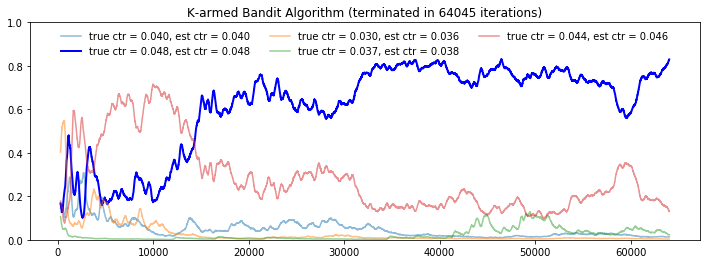

In [3]:
rolling=300
plot_history(ctrs, est_ctrs, history_p, 
             title="K-armed Bandit Algorithm (terminated in %i iterations)"%sum(traffic), rolling=rolling)

In [4]:
# turn winner's probability into data frame
cols = ["arm_%i_ctr=%.2f"%(i + 1, ctr) for i, ctr in enumerate(ctrs)]
data = {col : hist for col, hist in zip(cols, history_p)}
df_history_ma = pd.DataFrame(data).rolling(rolling).mean()

# turn click through ratre into data frame with same index, to be used as legend
data = {col : hist for col, hist in zip(cols, history_ctr)}
df_history_ctr = pd.DataFrame(data)

data = {col : hist for col, hist in zip(cols, history_alphas)}
df_history_alphas = pd.DataFrame(data)

data = {col : hist for col, hist in zip(cols, history_betas)}
df_history_betas = pd.DataFrame(data)

### Separate Plots

Text(0.5, 1.0, 'Mistakes 5-Armed Experiment')

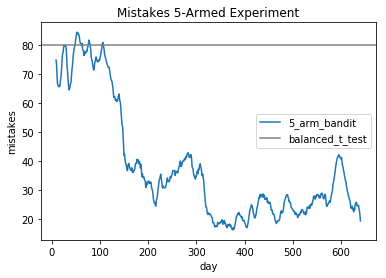

In [5]:
daily_traffic = 100
mistake = []
x = list(range(len(history_idx) // daily_traffic + 1))
for i in range(len(x)):
    idx_start, idx_end = i * daily_traffic, min(len(history_idx), (i + 1) * daily_traffic)
    mistake.append(sum(history_idx[idx_start : idx_end] != true_winner_idx))
mistake = pd.Series(mistake).rolling(10).mean()
plt.plot(x, mistake)
plt.xlabel('day')
plt.ylabel('mistakes')
plt.axhline(y=daily_traffic * (1 - 1 / len(ctrs)), color='grey')
plt.legend(['%i_arm_bandit'%len(ctrs), 'balanced_t_test'])
plt.title("Mistakes %i-Armed Experiment"%(len(ctrs)))
# plt.savefig("outputs/mistakes_%i_arm_bandit_seed_%i.png"%(len(ctrs), seed))

(0, 1)

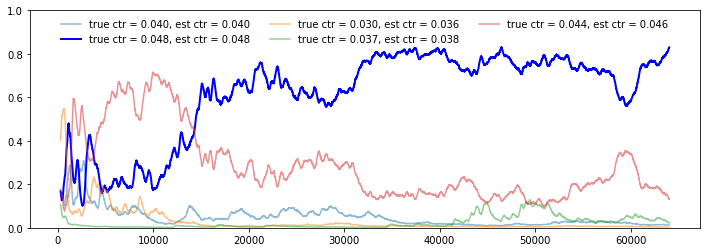

In [6]:
true_winner_idx = np.argmax(ctrs)
winner_idx = np.argmax(est_ctrs)

plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 1, 1)
for i, col in enumerate(cols):
    if i == true_winner_idx :
        ax.plot(df_history_ma[col], lw=2, color='b')
    elif i == winner_idx:
        ax.plot(df_history_ma[col], lw=2, color='r')
    else:
        ax.plot(df_history_ma[col], alpha=0.5)

legend = ["true ctr = %.3f, est ctr = %.3f"%(true, est) for true, est in zip(ctrs, est_ctrs)]
ax.legend(legend, frameon=False, loc='upper center', ncol=3)

ax.set_ylim(0, 1)

__convert__ x label to days (used later)

In [7]:
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [label[:-2] for label in labels]

In [8]:
labels[-1]

'700'

### Animate Line Plot

In [9]:
fps = 48
duration = 3

In [10]:
batch = int(sum(traffic) / (duration * fps))
print("batch", batch)
frames = []
for i in range(len(history_idx) // batch + 1):
    idx_end = min(len(history_idx) - 1, (i + 1) * batch)
    frames.append(idx_end)
    
# frames = frames[:30]

batch 444


In [11]:
from matplotlib.animation import FuncAnimation

daily_traffic = 100
mistake = []
x = list(range(len(history_idx) // daily_traffic + 1))
for i in range(len(x)):
    idx_start, idx_end = i * daily_traffic, min(len(history_idx), (i + 1) * daily_traffic)
    mistake.append(sum(history_idx[idx_start : idx_end] != true_winner_idx))
    
fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)

ax.plot(x, mistake)
ax.set_xlabel('day')
ax.set_ylabel('mistakes')
ax.axhline(y=daily_traffic * (1 - 1 / len(ctrs)), color='grey')
ax.legend(['%i_arm_bandit'%len(ctrs), 'balanced_t_test'])
ax.set_title("Mistakes %i-Armed Experiment"%(len(ctrs)))

i = 0
dot, = ax.plot(x[i], mistake[i], 'o', markersize=10)

def update(i):
    # important to convert iteration to day
    day = i // daily_traffic
    print('iteration %i'%i, end="\r")
    dot.set_xdata([x[day]])
    dot.set_ydata([mistake[day]])

    return dot, ax

anim = FuncAnimation(fig, update, frames=frames, interval=1000 / fps)

fname = 'outputs/animated_mistake_%is_%ifps_seed%i.gif'%(duration, fps, seed)
anim.save(fname, dpi=80, writer='imagemagick')
print(fname)

plt.close()

outputs/animated_mistake_3s_48fps_seed6.gif


### Combine Two Plots

outputs/grid_layout2_seed6.png


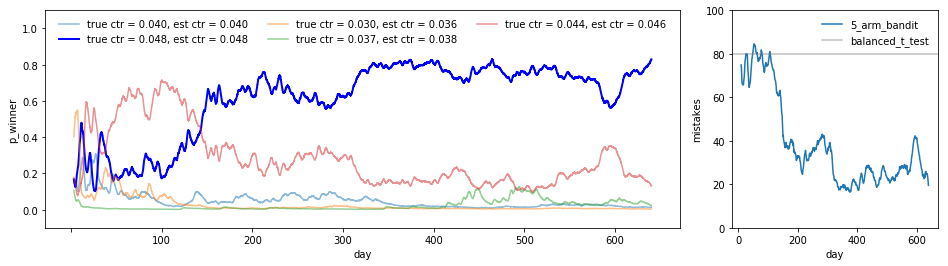

In [12]:
fig = plt.figure(figsize=(16, 4))
grid = plt.GridSpec(1, 11, hspace=2, wspace=1.5)

# ax1 --------------------------------------
ax1 = fig.add_subplot(grid[:, :-3])

true_winner_idx = np.argmax(ctrs)
winner_idx = np.argmax(est_ctrs)
for i, col in enumerate(cols):
    if i == true_winner_idx :
        ax1.plot(df_history_ma[col], lw=2, color='b')
    elif i == winner_idx:
        ax1.plot(df_history_ma[col], lw=2, color='r')
    else:
        ax1.plot(df_history_ma[col], alpha=0.5)

legend = ["true ctr = %.3f, est ctr = %.3f"%(true, est) for true, est in zip(ctrs, est_ctrs)]
ax1.legend(legend, frameon=False, loc='upper center', ncol=3)
ax1.set_xlabel('day')
ax1.set_ylabel('p_winner')
ax1.set_ylim(-0.1, 1.1)              
ax1.set_xticklabels(labels)

# ax2 --------------------------------------
ax2 = fig.add_subplot(grid[:, -3:])
daily_traffic = 100
mistake = []
x = list(range(len(history_idx) // daily_traffic + 1))
for i in range(len(x)):
    idx_start, idx_end = i * daily_traffic, min(len(history_idx), (i + 1) * daily_traffic)
    mistake.append(sum(history_idx[idx_start : idx_end] != true_winner_idx))
mistake = pd.Series(mistake).rolling(10).mean()

ax2.plot(x, mistake)
ax2.set_xlabel('day')
ax2.set_ylabel('mistakes')
ax2.axhline(y=daily_traffic * (1 - 1 / len(ctrs)), color='grey', alpha=0.5)
ax2.legend(['%i_arm_bandit'%len(ctrs), 'balanced_t_test'], frameon=False)
ax2.set_ylim(0, 100)

fname = "outputs/grid_layout2_seed%i.png"%seed
plt.savefig(fname, bbox_inches='tight', transparent=False)
print(fname)

plt.show()

### Animate Two Plots

In [13]:
fps = 48
duration = 3

In [14]:
batch = max(100, int(sum(traffic) / (duration * fps)))
print("batch", batch)
frames = []
for i in range(len(history_idx) // batch + 1):
    idx_end = min(len(history_idx) - 1, (i + 1) * batch)
    frames.append(idx_end)
    
# frames = frames[:30]

batch 444


In [15]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(16, 4))
grid = plt.GridSpec(1, 11, hspace=2, wspace=1.5)

# ax1 --------------------------------------
df_history = df_history_ma

color_dict = {}
lines = []
true_winner_idx = np.argmax(ctrs)
ax1 = fig.add_subplot(grid[:, :-3])

for i, col in enumerate(df_history_ma.columns):
    if i == true_winner_idx :
        line, = ax1.plot(df_history[col], lw=2, color='b')
    else:
        line, = ax1.plot(df_history[col], alpha=0.5)
    lines.append(line)
    color_dict[line] = line.get_color()
    
ax1.grid()
ax1.set(xlabel='day', ylabel='p_winner')
ax1.set_ylim(-0.1, 1.1)
ax1.set_xticklabels(labels)

# ax2 --------------------------------------
ax2 = fig.add_subplot(grid[:, -3:])
daily_traffic = 100
mistake = []
x = list(range(len(history_idx) // daily_traffic + 1))
for i in range(len(x)):
    idx_start, idx_end = i * daily_traffic, min(len(history_idx), (i + 1) * daily_traffic)
    mistake.append(sum(history_idx[idx_start : idx_end] != true_winner_idx))
mistake = pd.Series(mistake).rolling(10).mean()

ax2.plot(x, mistake, color='b', alpha=0.5)
ax2.set_xlabel('day')
ax2.set_ylabel('mistakes')
ax2.axhline(y=daily_traffic * (1 - 1 / len(ctrs)), color='grey')
ax2.legend(['%i_arm_bandit'%len(ctrs), 'balanced_t_test'], frameon=False)
ax2.set_title("Mistakes")
# ax2.set_xticklabels(labels)

i = 100
dot, = ax2.plot(x[i], mistake[i], 'o', markersize=10, color='b')

# animated part -----------------------------
def update(i):
    print('iteration %i'%i, end="\r")
    est_ctrs = df_history_ctr.iloc[i].values
    winner_idx = np.argmax(est_ctrs)
    
    for idx, (col, line) in enumerate(zip(df_history_ma.columns, lines)):
        line.set_ydata(df_history_ma[col][:i])
        line.set_xdata(df_history_ma[col][:i].index.values)
        
        # highlight wrong arm in red, correct arm in blue
        # may appear messy if switching is frequent
        if idx == true_winner_idx:
            line.set_color('b')
            line.set_lw(2)
            line.set_alpha(1)
        elif idx == winner_idx:
            line.set_color('r')
            line.set_lw(2)
            line.set_alpha(1)
        else:
            line.set_color(color_dict[line])
            line.set_lw(1)
            line.set_alpha(0.5)

    # important to convert iteration to day
    day = i // daily_traffic
    print('iteration %i'%i, end="\r")
    dot.set_xdata([x[day]])
    dot.set_ydata([mistake[day]])
    
    ax1.set_title("%i-armed Bandit Experiment (day %i)"%(len(ctrs), day))
        
    legend = ["true ctr = %.3f, est ctr = %.3f"%(true, est) for true, est in zip(ctrs, est_ctrs)]
    ax1.legend(legend, frameon=False, loc='upper center', ncol=3)

    return ax1, ax2

anim = FuncAnimation(fig, update, frames=frames, interval=1000 / fps)

fname = 'outputs/animated_grid2_%is_%ifps_seed%i.gif'%(duration, fps, seed)
anim.save(fname, dpi=80, writer='imagemagick')
print(fname)

plt.close()

outputs/animated_grid2_3s_48fps_seed6.gif


### Combine 3 Plots

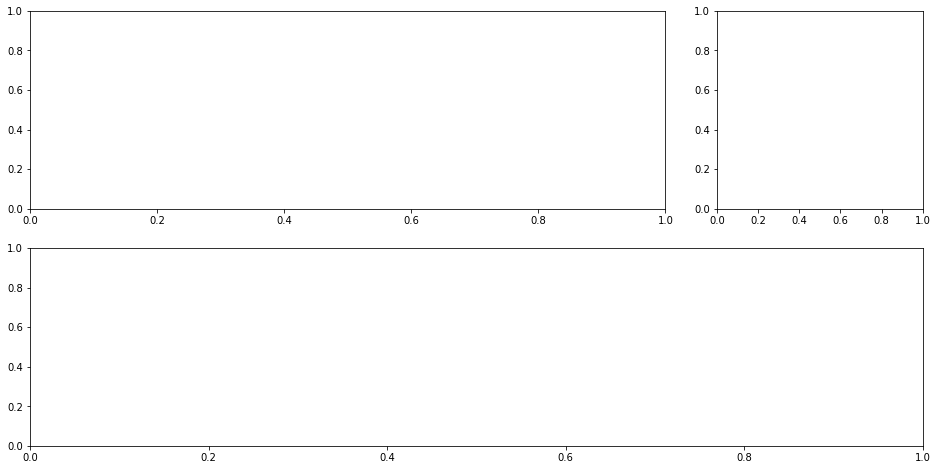

In [75]:
fig = plt.figure(figsize=(16, 8))
grid = plt.GridSpec(2, 11, hspace=0.2, wspace=1.5)

ax1 = fig.add_subplot(grid[:1, :-3])
ax2 = fig.add_subplot(grid[:1, -3:])
ax3 = fig.add_subplot(grid[1:, :])

390.5989403365866
outputs/grid_layout2_seed6.png


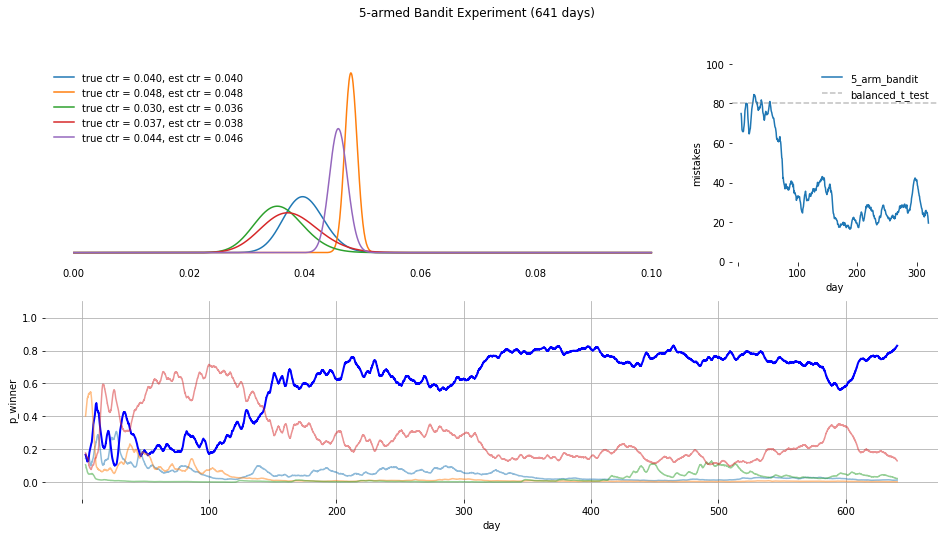

In [84]:
from matplotlib.animation import FuncAnimation
from scipy.stats import beta

fig = plt.figure(figsize=(16, 8))
grid = plt.GridSpec(2, 11, hspace=0.2, wspace=1.5)

ax1 = fig.add_subplot(grid[:1, :-3])
ax2 = fig.add_subplot(grid[:1, -3:])
ax3 = fig.add_subplot(grid[1:, :])

# ax1 --------------------------------------
x = np.linspace(0, 0.1, 1000)
idx = sum(traffic) - 1

alphas = df_history_alphas.loc[idx]
betas = df_history_betas.loc[idx]

y_max = 0
for col, a, b in zip(alphas.index.values, alphas, betas):
    rv = beta(a, b)
    y = rv.pdf(x)
    ax1.plot(x, y)
    y_max = max(y_max, max(y))
ax1.legend(legend, frameon=False, loc='upper left')
# ax1.grid()
# ax1.set_xlabel('p')
# ax1.set_ylabel('PDF')

# minimalism style
ax1.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
# ax1.axis('off')
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)

y_max += 20
print(y_max)

# ax2 --------------------------------------
daily_traffic = 100
mistake = []
x = list(range(len(history_idx) // daily_traffic + 1))
for i in range(len(x)):
    idx_start, idx_end = i * daily_traffic, min(len(history_idx), (i + 1) * daily_traffic)
    mistake.append(sum(history_idx[idx_start : idx_end] != true_winner_idx))
mistake = pd.Series(mistake).rolling(10).mean()

ax2.plot(x, mistake)
ax2.set_xlabel('day')
ax2.set_ylabel('mistakes')
ax2.axhline(y=daily_traffic * (1 - 1 / len(ctrs)), color='grey', alpha=0.5, linestyle='--')
ax2.legend(['%i_arm_bandit'%len(ctrs), 'balanced_t_test'], frameon=False)
ax2.set_ylim(0, 100)
ax2.set_xticklabels(labels)

# minimalism style
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.spines["bottom"].set_visible(False)

# ax3 --------------------------------------
true_winner_idx = np.argmax(ctrs)
winner_idx = np.argmax(est_ctrs)
for i, col in enumerate(cols):
    if i == true_winner_idx :
        ax3.plot(df_history_ma[col], lw=2, color='b')
    elif i == winner_idx:
        ax3.plot(df_history_ma[col], lw=2, color='r')
    else:
        ax3.plot(df_history_ma[col], alpha=0.5)

legend = ["true ctr = %.3f, est ctr = %.3f"%(true, est) for true, est in zip(ctrs, est_ctrs)]
# ax3.legend(legend, frameon=False, loc='upper center', ncol=3)
ax3.grid()
ax3.set_xlabel('day')
ax3.set_ylabel('p_winner')
ax3.set_ylim(-0.1, 1.1)              
ax3.set_xticklabels(labels)

# minimalism style
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["left"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

fig.suptitle("%i-armed Bandit Experiment (%i days)"%(len(ctrs), len(mistake)))

fname = "outputs/grid_layout2_seed%i.png"%seed
plt.savefig(fname, bbox_inches='tight', transparent=False)
print(fname)

plt.show()

### Animate Three Plots

In [18]:
fps = 48
duration = 3

In [19]:
batch = max(100, int(sum(traffic) / (duration * fps)))
print("batch", batch)
frames = []
for i in range(len(history_idx) // batch + 1):
    idx_end = min(len(history_idx) - 1, (i + 1) * batch)
    frames.append(idx_end)
    
# frames = frames[:30]

batch 444


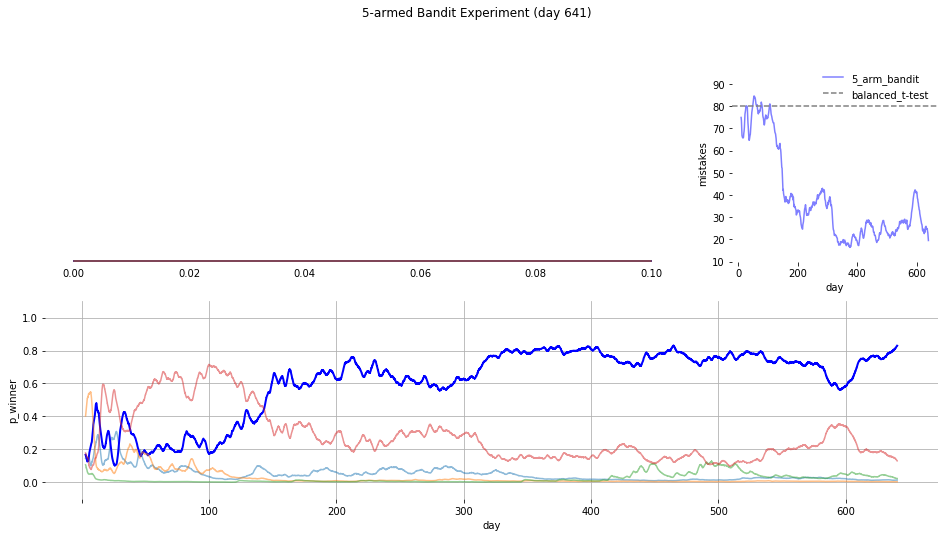

In [83]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(16, 8))
grid = plt.GridSpec(2, 11, hspace=0.2, wspace=1.5)
ax1 = fig.add_subplot(grid[:1, :-3])
ax3 = fig.add_subplot(grid[1:, :])
ax2 = fig.add_subplot(grid[:1, -3:])

# ax1 --------------------------------------
x3 = np.linspace(0, 0.1, 1000)

color_pdf = {}
pdfs = []

rv = beta(1, 1)

for i, col in enumerate(df_history_ma.columns):
    if i == true_winner_idx :
        pdf, = ax1.plot(x3, rv.pdf(x), lw=2, color='b')
    else:
        pdf, = ax1.plot(x3, rv.pdf(x), alpha=0.5)
    pdfs.append(pdf)
    color_pdf[pdf] = pdf.get_color()

# ax1.grid()
# ax1.set_xlabel('p')
# ax1.set_ylabel('PDF')
ax1.set_ylim(0, y_max)

# minimalism style
ax1.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
# ax1.axis('off')
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)

# ax2 --------------------------------------
daily_traffic = 100
mistake = []
x2 = list(range(len(history_idx) // daily_traffic + 1))
for i in range(len(x2)):
    idx_start, idx_end = i * daily_traffic, min(len(history_idx), (i + 1) * daily_traffic)
    mistake.append(sum(history_idx[idx_start : idx_end] != true_winner_idx))
mistake = pd.Series(mistake).rolling(10).mean()

ax2.plot(x2, mistake, color='b', alpha=0.5)
ax2.set_xlabel('day')
ax2.set_ylabel('mistakes')
ax2.axhline(y=daily_traffic * (1 - 1 / len(ctrs)), color='grey', linestyle='--')
ax2.legend(['%i_arm_bandit'%len(ctrs), 'balanced_t-test'], frameon=False, loc='upper right')
ax2.set_ylim(10, 99)

dot, = ax2.plot(x2[0], mistake[0], 'o', markersize=10, color='b')

# minimalism style
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.spines["bottom"].set_visible(False)

# ax3 --------------------------------------
df_history = df_history_ma
true_winner_idx = np.argmax(ctrs)

color_dict = {}
lines = []

for i, col in enumerate(df_history_ma.columns):
    if i == true_winner_idx :
        line, = ax3.plot(df_history[col], lw=2, color='b')
    else:
        line, = ax3.plot(df_history[col], alpha=0.5)
    lines.append(line)
    color_dict[line] = line.get_color()
    
ax3.grid()
ax3.set(xlabel='day', ylabel='p_winner')
ax3.set_ylim(-0.1, 1.1)
ax3.set_xticklabels(labels)

fig.suptitle("%i-armed Bandit Experiment (day %i)"%(len(ctrs), len(mistake)))

# minimalism style
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["left"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

In [82]:
# animated part -----------------------------
def update(i):
    print('iteration %i'%i, end="\r")
    est_ctrs = df_history_ctr.iloc[i].values
    winner_idx = np.argmax(est_ctrs)
    legend = ["true ctr = %.3f, est ctr = %.3f"%(true, est) for true, est in zip(ctrs, est_ctrs)]
    day = i // daily_traffic
    
    # update title, legends
    fig.suptitle("%i-armed Bandit Experiment (day %i)"%(len(ctrs), day))
    ax1.legend(legend, frameon=False, loc='upper left')
    
    # animate ax1
    alphas = df_history_alphas.loc[i]
    betas = df_history_betas.loc[i]
    
    for idx, (col, a, b, pdf) in enumerate(zip(alphas.index.values, alphas, betas, pdfs)):
        rv = beta(a, b)
        pdf.set_ydata(rv.pdf(x3))
    
    # animate ax2, important to convert iteration to day
    print('iteration %i'%i, end="\r")
    dot.set_xdata([x2[day]])
    dot.set_ydata([mistake[day]])
    
    # animate ax3
    for idx, (col, line) in enumerate(zip(df_history_ma.columns, lines)):
        line.set_ydata(df_history_ma[col][:i])
        line.set_xdata(df_history_ma[col][:i].index.values)
        
        # highlight wrong arm in red, correct arm in blue
        # may appear messy if switching is frequent
        if idx == true_winner_idx:
            line.set_color('b')
            line.set_lw(2)
            line.set_alpha(1)
        elif idx == winner_idx:
            line.set_color('r')
            line.set_lw(2)
            line.set_alpha(1)
        else:
            line.set_color(color_dict[line])
            line.set_lw(1)
            line.set_alpha(0.5)

    return ax3, ax2, ax1

anim = FuncAnimation(fig, update, frames=frames, interval=1000 / fps)
fname = 'outputs/animated_grid3_%is_%ifps_seed%i.gif'%(duration, fps, seed)
anim.save(fname, dpi=80, writer='imagemagick')
print(fname)

plt.close()

outputs/animated_grid3_3s_48fps_seed6.gif
